# RESEARCH TRACK 2
## ASSIGNMENT 2 - ROS & JUPYTER NOTEBOOKS

### About this notebook:
- This notebook replaces the previous node (set_target.py) that required writing the target coordinates via the terminal using the specified 'rostopic'. We are also able to cancel the sent target.
- We are able to generate a plot to visualize the robot's and target's positions.
- A plot that shows both the number of reached and non-reached targets is also included.


### Disclaimer:
- Please refer to the README file at the workspace root for the launch of the ROS package.
- Live plotting was able to work on personal Ubuntu but not on the Docker Image. On Docker, the last block needs to be re-run for plot changes.

## Imports

In [1]:
import rospy
import time
import statistics

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import numpy as np

from actionlib import SimpleActionClient
from std_msgs.msg import Empty
from nav_msgs.msg import Odometry
from assignment_2_2023.msg import PlanningAction, PlanningGoal
from rt1_pkg.msg import TargetPos, RobotPosVel


## Global variables

In [2]:
# Counters
reached_number = 0
cancelled_number = 0

# Booleans (for status)
active = False
just_cancelled = False

## Widget configuration

In [3]:
# User input of X,Y coordinates
x_value = widgets.FloatText(description = 'X:', layout = widgets.Layout(height = '50px', width = '200px'))
y_value = widgets.FloatText(description = 'Y:', layout = widgets.Layout(height = '50px', width = '200px'))

# Buttons
send_button = widgets.Button(description = 'Send')
cancel_button = widgets.Button(description = 'Cancel')

# Text Data
message = widgets.Text(description = 'Message', disabled = True, layout = widgets.Layout(height = '50px', width = '300px'))
cancelled_targets = widgets.Text(description = '# of Cancelled:', disabled = True, layout = widgets.Layout(height = '50px', width = '200px')) 
reached_targets = widgets.Text(description = '# of Reached:', disabled = True, layout = widgets.Layout(height = '50px', width = '200px')) 

## Visualizer Class

In [4]:
class Visualizer:
    
    def __init__(self):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2)  # Create 2 plots horizontally
        
        # Line plot for trajectory
        self.ln, = self.ax1.plot([], [], 'ro-', linewidth=0.8)
        self.x_coord, self.y_coord = [], []

        # Line plot for targets
        self.target_ln, = self.ax1.plot([], [], 'bo', linewidth=1.0)
        self.target_x_coord, self.target_y_coord = [], []

        # Bar plot: reached vs cancelled targets
        self.bar_labels = ['Reached', 'Cancelled']
        self.bar_data = [reached_number, cancelled_number]
        self.bar = self.ax2.bar(self.bar_labels, self.bar_data, color=['blue', 'red'])
        
        
    def plot_init(self):
        # Line plot: trajectory
        self.ax1.set_title('Trajectory & Targets', fontsize=10)
        self.ax1.set_xlabel('X')
        self.ax1.set_ylabel('Y')
        self.ax1.set_xlim(-5, 5)
        self.ax1.set_ylim(-5, 5)
        self.ax1.grid(True)
        
        # Bar plot: reached vs cancelled targets   
        self.ax2.set_title('Reached vs Cancelled', fontsize=10)
        self.ax2.set_ylabel('Number', fontsize=9)
        self.ax2.grid(True)
        self.ax2.tick_params(axis='both', which='major', labelsize=9)
        self.ax2.set_ylim(0, 5.5)
        
        return self.ln, self.target_ln
    
    def update_plots(self, frame):
        # Line plot: trajectory
        self.ln.set_data(self.x_coord, self.y_coord)
        self.target_ln.set_data(self.target_x_coord, self.target_y_coord)
        
        # Bar plot: reached vs cancelled targets  
        max_count = max(reached_number, cancelled_number)
        max_height = max(5, max_count)
        self.ax2.set_ylim(0, max_height*1.1)
        tick_interval = max(1, max_height // 5)
        self.ax2.yaxis.set_major_locator(plt.MultipleLocator(tick_interval)) 
        self.bar[0].set_height(reached_number)
        self.bar[1].set_height(cancelled_number)
    
        return self.bar, self.ln, self.target_ln
    
    def odom_callback(self, msg):
        pos_x = msg.pose.pose.position.x
        pos_y = msg.pose.pose.position.y
        self.x_coord.append(pos_x)
        self.y_coord.append(pos_y)
        
    def add_target(self, target_x, target_y):
        self.target_x_coord.append(target_x)
        self.target_y_coord.append(target_y)
        self.update_plots(None)  # Update the plot to reflect new target
        

## ROS Functions

In [5]:
def send_target(data):
    goal = PlanningGoal()
    goal.target_pose.pose.position.x = x_value.value
    goal.target_pose.pose.position.y = y_value.value
    message.value = 'Goal sent'
    ac.send_goal(goal, done_cb=done_callback, active_cb=active_callback, feedback_cb=feedback_callback)
    vis.add_target(x_value.value, y_value.value)
    

def cancel_target(data):
    global cancelled_number, active, just_cancelled
    
    if not active:
        message.value = 'Nothing to cancel'
        return

    active = False
    just_cancelled = True
    
    cancelled_number += 1
    message.value = 'Goal cancelled'
    cancelled_targets.value = f'{cancelled_number}'
    ac.cancel_goal()


def done_callback(state, result):
    global reached_number, active, just_cancelled
    
    if not just_cancelled:
        reached_number += 1
        message.value = '¡Goal reached!'
        reached_targets.value = f'{reached_number}'
        
    active = False
    just_cancelled = False
    
    
def feedback_callback(feedback):
    pass
    
    
def active_callback():
    global active
    active = True
    


## ROS Initialization

In [6]:
rospy.init_node('set_target')

#: Initialize SimpleActionClient for the 'reaching_goal' action
ac = SimpleActionClient('/reaching_goal', PlanningAction)

#: Initialize publisher for 'RobotPosVel'
pub = rospy.Publisher('/robot_pos_vel', RobotPosVel, queue_size=10)


## Plots and widgets

/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


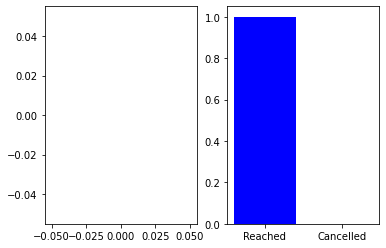

In [8]:
# Visualizer object
vis = Visualizer()

# Odometry
rospy.Subscriber('/odom', Odometry, vis.odom_callback)

# When button pressed...
send_button.on_click(send_target)
cancel_button.on_click(cancel_target)

# Create the animation
ani = FuncAnimation(vis.fig, vis.update_plots, init_func=vis.plot_init, save_count = 20)
plt.show(block=True)

# Display the widgets
display(widgets.VBox([
    widgets.HBox([x_value, y_value]),
    widgets.HBox([send_button, cancel_button]), 
    widgets.HBox([message]),
    widgets.HBox([cancelled_targets]),
    widgets.HBox([reached_targets])
]))


